# Analysis of cross-sectional MRI data from the Open Access Series of Imaging Studies (OASIS)

- We perform an initial exploratory analysis of a portion of the [OASIS1 dataset](http://www.oasis-brains.org/#oasis1)

- We then use a 2-layer NN to predict whether patients have dementia

- The response variable (*clinical dementia rating*) has four possible values, which makes this is a classification problem

- Note that the dataset can also be downloaded from [Kaggle](https://www.kaggle.com/jboysen/mri-and-alzheimers)

In [320]:
# import libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

from matplotlib import rcParams

rcParams['figure.figsize'] = 10,8
sns.set_style('whitegrid')

file1 = './datasets/oasis_cross-sectional.csv'
file2 = './datasets/oasis_longitudinal.csv'

## 1. Initial exploratory analysis

In [321]:
# what does data look like
df = pd.read_csv(file1)
df.head()

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN


In [322]:
# split up 'ID' into two variables: ID number and visit number

ID_variables = np.array([x.split('_')[1:] for x in df['ID']]) # split ID by underscore '_'

ID_variables[:,1] = [x.replace('MR','') for x in ID_variables[:,1]] # remove 'MR' from visit number

ID_variables[:,0] = ID_variables[:,0].astype(int) # convert to int
ID_variables[:,1] = ID_variables[:,1].astype(int) # convert to int

ID_variables = pd.DataFrame(ID_variables,columns=['Subject ID','Visit'])

df = pd.concat([df, ID_variables],axis=1) # add to data frame

df = df.drop(columns='ID') # replace ID with the subject ID
df.index = df['Subject ID']
df = df.drop(columns='Subject ID')

# set 'Delay' to 0 for first visits

df['Delay'] = df['Delay'].fillna(0)

In [323]:
#   Variable descriptions
#   source: http://www.oasis-brains.org/files/oasis_cross-sectional_facts.pdf
#________________________________________________
#   1. demographic variables
#
#      variable descriptions
#         M/F   gender
#         Hand  left vs right handed
#         Age   age
#         Educ  education
#         SES   socioeconomic status
#________________________________________________
#   2. clinical variables
#
#      variable descriptions 
#         MMSE  mini-mental state exam
#         CDR   clinical dementia rating (0 - not demented, 2 - moderate dementia)
#________________________________________________
#   3. derived anatomical volumes
#
#      variable descriptions
#         eTIV  est. total intracranial volume
#         nWBV  normalized whole brian volume
#         ASF   atlas scaling factor
#         Delay [? maybe for same patient, its the delay between scans]

In [326]:
# convert to categorical variables

df['M/F'] = pd.Categorical(df['M/F'])
df['Hand'] = pd.Categorical(df['Hand'])
df['Educ'] = pd.Categorical(df['Educ'])
df['SES'] = pd.Categorical(df['SES'])

In [327]:
df.dtypes

M/F      category
Hand     category
Age         int64
Educ     category
SES      category
MMSE      float64
CDR       float64
eTIV        int64
nWBV      float64
ASF       float64
Delay     float64
Visit      object
dtype: object

In [328]:
# what do categorical variables look like

df_cat = df[['M/F','Hand','Educ','SES']]
df_cat.describe()

,M/F,Hand,Educ,SES
count,436,436,235.0,216.0
unique,2,1,5.0,5.0
top,F,R,2.0,2.0
freq,268,436,64.0,65.0


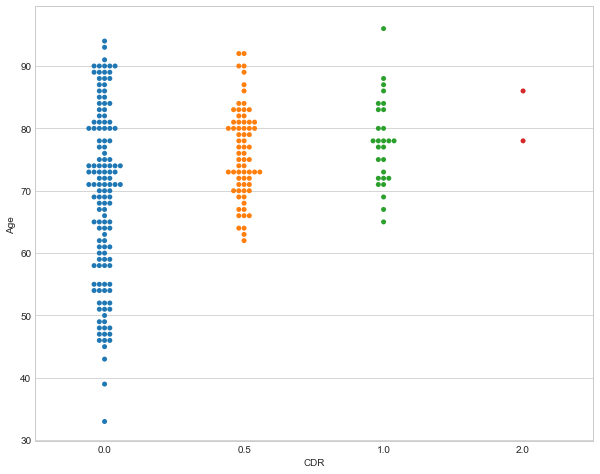

In [329]:
sns.swarmplot(x='CDR',y='Age',data=df) # CDR is correlated with age

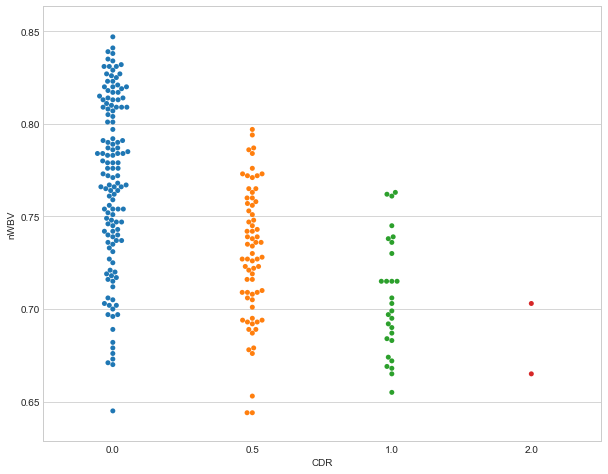

In [330]:
sns.swarmplot(x='CDR',y='nWBV',data=df) #CDR is anti-correlated with brain volume

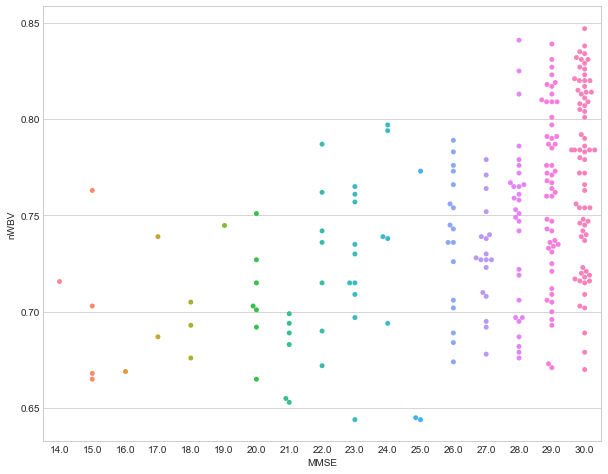

In [331]:
sns.swarmplot(x='MMSE',y='nWBV',data=df) # MMSE correlated with brain volume

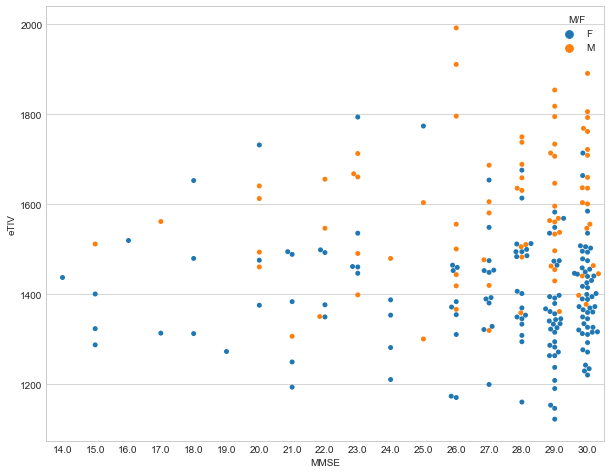

In [332]:
sns.swarmplot(x='MMSE',y='eTIV',hue='M/F',data=df) # hard to see correlation here

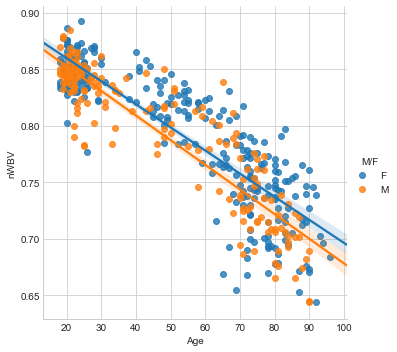

In [333]:
sns.lmplot(x='Age',y='nWBV',hue='M/F',data=df) # high correlation betwen age and nwbv

In [334]:
# get rid of NA for analysis

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

cat_columns = df.select_dtypes(['category']).columns
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

In [335]:
df.describe()

,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
count,216.000000,216.0,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.0
mean,0.328704,0.0,72.444444,2.231481,1.490741,27.324074,0.261574,1458.638889,0.750500,1.217176,0.0
std,0.470833,0.0,12.306424,1.333689,1.120593,3.436680,0.382593,160.523125,0.048271,0.128858,0.0
min,0.000000,0.0,33.000000,0.000000,0.000000,15.000000,0.000000,1123.000000,0.644000,0.881000,0.0
25%,0.000000,0.0,66.000000,1.000000,1.000000,26.000000,0.000000,1346.000000,0.715000,1.141750,0.0
50%,0.000000,0.0,73.000000,2.000000,1.000000,29.000000,0.000000,1445.500000,0.748500,1.214500,0.0
75%,1.000000,0.0,81.000000,3.000000,2.000000,30.000000,0.500000,1536.500000,0.786000,1.304000,0.0
max,1.000000,0.0,96.000000,4.000000,4.000000,30.000000,2.000000,1992.000000,0.841000,1.563000,0.0


In [336]:
# pick which variables to use for analysis

Y = df['CDR']
X = df[['eTIV', 'nWBV','Age','Educ','SES','M/F']]
X = sm.add_constant(X)

In [337]:
full_model = sm.OLS(Y.astype(float),X.astype(float),missing='drop').fit()

In [338]:
full_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CDR   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     13.89
Date:                Sat, 26 May 2018   Prob (F-statistic):           2.82e-13
Time:                        23:02:09   Log-Likelihood:                -62.219
No. Observations:                 216   AIC:                             138.4
Df Residuals:                     209   BIC:                             162.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9387      0.786      5.008      0.000       2.388       5.489
eTIV         7.08e-05      0.000      0.403      0.688      -0.000       0.000
nWBV          -4.5439      0.718     -6.330      0.000      -5.959      -3.129
Age           -0.0046      0.003     -1.668      0.097      -0.010       0.001
Educ          -0.0332      0.025     -1.309      0.192      -0.083       0.017
SES            0.0250      0.030      0.834      0.405      -0.034       0.084
M/F           -0.0005      0.058     -0.009      0.993      -0.115       0.114
==============================================================================
Omnibus:                       47.858   Durbin-Watson:                   1.750
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.078
Skew:                           1.047   Prob(JB):                     6.82e-23
Kurtosis:                       5.638   Cond. No.                     6.89e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.89e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [73]:
X_reduced = df[['nWBV','Age','Educ']]
X_reduced = sm.add_constant(X_reduced)

In [74]:
reduced_model = sm.OLS(Y.astype(float),X_reduced.astype(float),missing='drop').fit()
reduced_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CDR   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     27.77
Date:                Sat, 26 May 2018   Prob (F-statistic):           3.45e-15
Time:                        22:03:03   Log-Likelihood:                -62.661
No. Observations:                 216   AIC:                             133.3
Df Residuals:                     212   BIC:                             146.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1808      0.669      6.252      0.000       2.863       5.499
nWBV          -4.6236      0.682     -6.784      0.000      -5.967      -3.280
Age           -0.0047      0.003     -1.764      0.079      -0.010       0.001
Educ          -0.0472      0.017     -2.764      0.006      -0.081      -0.014
==============================================================================
Omnibus:                       47.489   Durbin-Watson:                   1.744
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.134
Skew:                           1.040   Prob(JB):                     1.09e-22
Kurtosis:                       5.629   Cond. No.                     3.14e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.14e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [75]:
# diagnostic plots
# for interpretation, see: http://data.library.virginia.edu/diagnostic-plots/
# code from https://medium.com/@emredjan/emulating-r-regression-plots-in-python-43741952c034

# fitted values (need a constant term for intercept)
model_fitted_y = reduced_model.fittedvalues

# model residuals
model_residuals = reduced_model.resid

# normalized residuals
model_norm_residuals = reduced_model.get_influence().resid_studentized_internal

# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

# absolute residuals
model_abs_resid = np.abs(model_residuals)

# leverage, from statsmodels internals
model_leverage = reduced_model.get_influence().hat_matrix_diag

# cook's distance, from statsmodels internals
model_cooks = reduced_model.get_influence().cooks_distance[0]

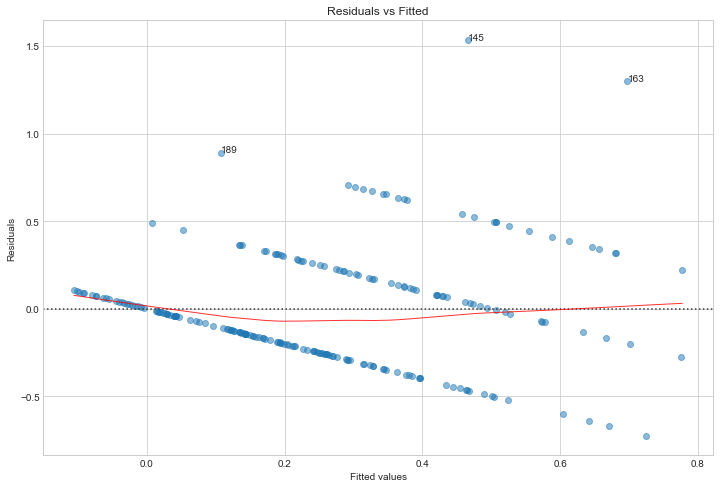

In [76]:
# residual plot
plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(8)
plot_lm_1.set_figwidth(12)

plot_lm_1.axes[0] = sns.residplot(model_fitted_y, Y, 
                          lowess=True, 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')

# annotations
abs_resid = model_abs_resid.sort_values(ascending=False)
abs_resid_top_3 = abs_resid[:3]

for i in abs_resid_top_3.index:
    plot_lm_1.axes[0].annotate(i, 
                               xy=(model_fitted_y[i], 
                                   model_residuals[i]));

The issue with regression is that CDR is really a categorical variable, so this is really a classification problem

Let's try a neural network!

## 2. Neural network

In [176]:
# convert M/F to one-hot
X['Female'] = (X['M/F']==0)*1
X['Male'] = (X['M/F']==1)*1

In [177]:
# convert Educ to one-hot
X['LessHS-1'] = (X['Educ']==1)*1
X['HS-2'] = (X['Educ']==2)*1
X['SomeCollege-3'] = (X['Educ']==3)*1
X['College-4'] = (X['Educ']==4)*1
#X['BeyondCollege-5'] = (X['Educ']==5)*1

In [178]:
# drop M/F and Educ columns
X = X.drop(columns=['const','M/F','Educ']) # replace ID with the subject ID

In [180]:
X.drop(columns='SES') # not clear how these are ordered... the paper referenced by OASIS does not mention socioeconomic status

,eTIV,nWBV,Age,Female,Male,LessHS-1,HS-2,SomeCollege-3,College-4
0,1344,0.743,74,1,0,1,0,0,0
1,1147,0.810,55,1,0,0,0,1,0
2,1454,0.708,73,1,0,0,0,1,0
3,1636,0.689,74,0,1,0,0,0,1
4,1321,0.827,52,1,0,0,1,0,0
5,1664,0.679,81,1,0,0,0,0,1
6,1477,0.739,82,0,1,1,0,0,0
7,1636,0.813,39,0,1,0,1,0,0
8,1536,0.715,89,1,0,0,0,0,1
9,1326,0.785,48,1,0,0,0,0,1


In [181]:
X.dtypes

eTIV               int64
nWBV             float64
Age                int64
SES                 int8
Female             int64
Male               int64
LessHS-1           int64
HS-2               int64
SomeCollege-3      int64
College-4          int64
dtype: object

In [286]:
X = X.astype(float)

X.dtypes

eTIV             float64
nWBV             float64
Age              float64
SES              float64
Female           float64
Male             float64
LessHS-1         float64
HS-2             float64
SomeCollege-3    float64
College-4        float64
dtype: object

In [290]:
from sklearn.preprocessing import MinMaxScaler # scale inputs
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled

array([[0.2543153 , 0.50253807, 0.65079365, ..., 0.        , 0.        ,
        0.        ],
       [0.02761795, 0.84263959, 0.34920635, ..., 0.        , 1.        ,
        0.        ],
       [0.38089758, 0.3248731 , 0.63492063, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.26582278, 0.91878173, 0.44444444, ..., 0.        , 0.        ,
        0.        ],
       [0.59148446, 0.69035533, 0.44444444, ..., 0.        , 0.        ,
        1.        ],
       [0.28653625, 0.61928934, 0.46031746, ..., 1.        , 0.        ,
        0.        ]])

In [291]:
# convert Y to one-hot
from keras.utils import np_utils

Y_scaled = (Y*2).astype(int)
Y_scaled = np_utils.to_categorical(Y_scaled,5)
Y_scaled

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [307]:
from sklearn.model_selection import train_test_split

test_size = 0.2

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_rescaled, test_size=test_size, random_state=0)

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 172
number of test examples = 44
X_train shape: (172, 10)
Y_train shape: (172, 5)
X_test shape: (44, 10)
Y_test shape: (44, 5)


In [314]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras import optimizers

input_dim = X_train.shape[1]

model = Sequential()
#model.add(BatchNormalization())
model.add(Dense(12, input_dim=input_dim, activation='relu'))
#model.add(Dense(8, input_dim=input_dim, activation='relu'))
model.add(BatchNormalization())
#model.add(Dense(8, input_dim=8, activation='relu'))
model.add(Dense(5, activation='softmax'))

adam = optimizers.Adam(lr=0.0001)

In [315]:
# Compile model
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [316]:
history = model.fit(X_train, Y_train, epochs=500, batch_size=43, verbose=1)

Epoch 1/500
172/172 [==============================] - 1s 8ms/step - loss: 2.0198 - acc: 0.1512
Epoch 2/500
172/172 [==============================] - 0s 104us/step - loss: 2.0198 - acc: 0.1512
Epoch 3/500
172/172 [==============================] - 0s 113us/step - loss: 2.0132 - acc: 0.1453
Epoch 4/500
172/172 [==============================] - 0s 109us/step - loss: 2.0201 - acc: 0.1512
Epoch 5/500
172/172 [==============================] - 0s 108us/step - loss: 1.9996 - acc: 0.1512
Epoch 6/500
172/172 [==============================] - 0s 111us/step - loss: 1.9963 - acc: 0.1512
Epoch 7/500
172/172 [==============================] - 0s 108us/step - loss: 1.9948 - acc: 0.1453
Epoch 8/500
172/172 [==============================] - 0s 110us/step - loss: 1.9940 - acc: 0.1512
Epoch 9/500
172/172 [==============================] - 0s 106us/step - loss: 1.9831 - acc: 0.1512
Epoch 10/500
172/172 [==============================] - 0s 98us/step - loss: 1.9913 - acc: 0.1512
Epoch 11/500
172/172 [

172/172 [==============================] - 0s 124us/step - loss: 1.7323 - acc: 0.1744
Epoch 84/500
172/172 [==============================] - 0s 145us/step - loss: 1.7236 - acc: 0.1744
Epoch 85/500
172/172 [==============================] - 0s 124us/step - loss: 1.7324 - acc: 0.1919
Epoch 86/500
172/172 [==============================] - 0s 124us/step - loss: 1.7253 - acc: 0.1686
Epoch 87/500
172/172 [==============================] - 0s 120us/step - loss: 1.7284 - acc: 0.1919
Epoch 88/500
172/172 [==============================] - 0s 111us/step - loss: 1.7028 - acc: 0.1686
Epoch 89/500
172/172 [==============================] - 0s 129us/step - loss: 1.7068 - acc: 0.1686
Epoch 90/500
172/172 [==============================] - 0s 132us/step - loss: 1.7017 - acc: 0.1802
Epoch 91/500
172/172 [==============================] - 0s 138us/step - loss: 1.7048 - acc: 0.1860
Epoch 92/500
172/172 [==============================] - 0s 110us/step - loss: 1.7045 - acc: 0.1860
Epoch 93/500
172/172 [=

172/172 [==============================] - 0s 127us/step - loss: 1.5358 - acc: 0.2849
Epoch 166/500
172/172 [==============================] - 0s 122us/step - loss: 1.5318 - acc: 0.3023
Epoch 167/500
172/172 [==============================] - 0s 132us/step - loss: 1.5371 - acc: 0.2791
Epoch 168/500
172/172 [==============================] - 0s 126us/step - loss: 1.5504 - acc: 0.2849
Epoch 169/500
172/172 [==============================] - 0s 118us/step - loss: 1.5338 - acc: 0.2965
Epoch 170/500
172/172 [==============================] - 0s 134us/step - loss: 1.5354 - acc: 0.2558
Epoch 171/500
172/172 [==============================] - 0s 138us/step - loss: 1.5262 - acc: 0.3140
Epoch 172/500
172/172 [==============================] - 0s 117us/step - loss: 1.5253 - acc: 0.2849
Epoch 173/500
172/172 [==============================] - 0s 120us/step - loss: 1.5319 - acc: 0.2791
Epoch 174/500
172/172 [==============================] - 0s 127us/step - loss: 1.5309 - acc: 0.2965
Epoch 175/500


172/172 [==============================] - 0s 137us/step - loss: 1.3945 - acc: 0.4244
Epoch 248/500
172/172 [==============================] - 0s 128us/step - loss: 1.4047 - acc: 0.4070
Epoch 249/500
172/172 [==============================] - 0s 107us/step - loss: 1.3866 - acc: 0.4360
Epoch 250/500
172/172 [==============================] - 0s 125us/step - loss: 1.3904 - acc: 0.4186
Epoch 251/500
172/172 [==============================] - 0s 115us/step - loss: 1.3928 - acc: 0.4070
Epoch 252/500
172/172 [==============================] - 0s 111us/step - loss: 1.3838 - acc: 0.4244
Epoch 253/500
172/172 [==============================] - 0s 109us/step - loss: 1.4106 - acc: 0.4244
Epoch 254/500
172/172 [==============================] - 0s 103us/step - loss: 1.3751 - acc: 0.4535
Epoch 255/500
172/172 [==============================] - 0s 113us/step - loss: 1.3837 - acc: 0.4419
Epoch 256/500
172/172 [==============================] - 0s 125us/step - loss: 1.3735 - acc: 0.4535
Epoch 257/500


172/172 [==============================] - 0s 125us/step - loss: 1.2595 - acc: 0.5407
Epoch 330/500
172/172 [==============================] - 0s 108us/step - loss: 1.2851 - acc: 0.5058
Epoch 331/500
172/172 [==============================] - 0s 129us/step - loss: 1.2720 - acc: 0.5291
Epoch 332/500
172/172 [==============================] - 0s 120us/step - loss: 1.2543 - acc: 0.5233
Epoch 333/500
172/172 [==============================] - 0s 115us/step - loss: 1.2576 - acc: 0.5291
Epoch 334/500
172/172 [==============================] - 0s 119us/step - loss: 1.2673 - acc: 0.5233
Epoch 335/500
172/172 [==============================] - 0s 124us/step - loss: 1.2647 - acc: 0.5349
Epoch 336/500
172/172 [==============================] - 0s 123us/step - loss: 1.2582 - acc: 0.5174
Epoch 337/500
172/172 [==============================] - 0s 136us/step - loss: 1.2499 - acc: 0.5407
Epoch 338/500
172/172 [==============================] - 0s 171us/step - loss: 1.2523 - acc: 0.5349
Epoch 339/500


172/172 [==============================] - 0s 144us/step - loss: 1.1611 - acc: 0.5523
Epoch 411/500
172/172 [==============================] - 0s 139us/step - loss: 1.1547 - acc: 0.5814
Epoch 412/500
172/172 [==============================] - 0s 108us/step - loss: 1.1562 - acc: 0.6047
Epoch 413/500
172/172 [==============================] - 0s 114us/step - loss: 1.1631 - acc: 0.5465
Epoch 414/500
172/172 [==============================] - 0s 130us/step - loss: 1.1572 - acc: 0.5698
Epoch 415/500
172/172 [==============================] - 0s 149us/step - loss: 1.1737 - acc: 0.5698
Epoch 416/500
172/172 [==============================] - 0s 121us/step - loss: 1.1514 - acc: 0.5756
Epoch 417/500
172/172 [==============================] - 0s 136us/step - loss: 1.1600 - acc: 0.5814
Epoch 418/500
172/172 [==============================] - 0s 115us/step - loss: 1.1561 - acc: 0.5640
Epoch 419/500
172/172 [==============================] - 0s 117us/step - loss: 1.1495 - acc: 0.5756
Epoch 420/500


172/172 [==============================] - 0s 117us/step - loss: 1.0772 - acc: 0.6047
Epoch 493/500
172/172 [==============================] - 0s 121us/step - loss: 1.0783 - acc: 0.5814
Epoch 494/500
172/172 [==============================] - 0s 134us/step - loss: 1.0778 - acc: 0.5698
Epoch 495/500
172/172 [==============================] - 0s 117us/step - loss: 1.0813 - acc: 0.5930
Epoch 496/500
172/172 [==============================] - 0s 129us/step - loss: 1.0807 - acc: 0.5756
Epoch 497/500
172/172 [==============================] - 0s 113us/step - loss: 1.0751 - acc: 0.5988
Epoch 498/500
172/172 [==============================] - 0s 134us/step - loss: 1.0778 - acc: 0.5640
Epoch 499/500
172/172 [==============================] - 0s 116us/step - loss: 1.0679 - acc: 0.5756
Epoch 500/500
172/172 [==============================] - 0s 120us/step - loss: 1.0718 - acc: 0.5930


In [317]:
preds = model.evaluate(X_test,Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

44/44 [==============================] - 0s 11ms/step
Loss = 1.1695957508954136
Test Accuracy = 0.6136363582177595


In [318]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 12)                132       
_________________________________________________________________
batch_normalization_12 (Batc (None, 12)                48        
_________________________________________________________________
dense_73 (Dense)             (None, 5)                 65        
Total params: 245
Trainable params: 221
Non-trainable params: 24
_________________________________________________________________


Text(0,0.5,'Accuracy (training set)')

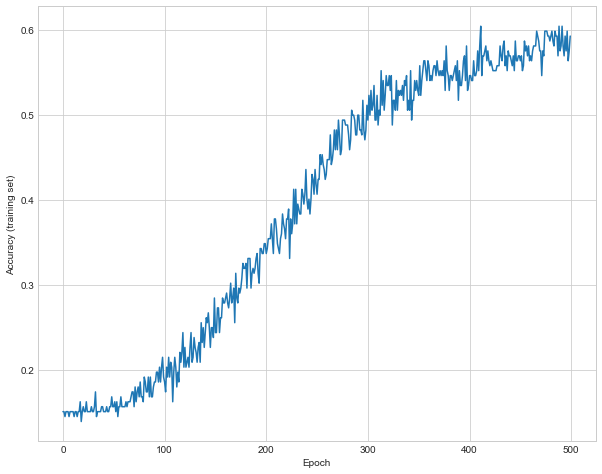

In [319]:
plt.plot(history.history['acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy (training set)')